In [2]:
import os
import subprocess

# autoreload any .py scripts
%load_ext autoreload
%autoreload 2

# set the project's root directory as the notebooks' working directory
# git_root = subprocess.run(['git', 'rev-parse', '--show-toplevel'], capture_output=True, text=True).stdout.strip()
if os.getcwd().endswith("notebooks"): os.chdir("..")
os.getcwd()


'/Users/nilsgandlau/code/browser-automation'

In [1]:
from typing import Callable, Literal, get_type_hints, Union, Annotated, _AnnotatedAlias, _LiteralGenericAlias
import json
import pdb

from enum import Enum
import typing


class OpenAIDataTypes(Enum):
    """OpenAI uses https://json-schema.org/understanding-json-schema/reference/type"""
    str = "string"
    int = "integer"
    float = "number"
    bool = "boolean"
    list = "array"
    NoneType = "null"
    object = "object"

    def get_mapping():
        return {dtype.name: dtype.value for dtype in OpenAIDataTypes}


def convert_to_openai_tool(func: Callable) -> str:
    """Converts a Python function into an OpenAI-formatted Assistant tool."""
    properties = {} # the `properties` field for OpenAI formatted tools
    required = []

    type_hints = get_type_hints(func, include_extras=True)
    for param, hint in type_hints.items():
        # check if the type hint of the argument has a standard type (int, str, float)
        # without any Annotation[] or Optional[] hint.
        if isinstance(hint, type):
            dtype = OpenAIDataTypes.get_mapping()[hint.__name__]
            description = ""
            required.append(param)
            properties[param] = {"type": dtype, "description": description}
        # check if the type hint of the argument has an Optional[] hint.
        elif hint.__name__ == "Optional":
            dtype = OpenAIDataTypes.get_mapping()[hint.__args__[0].__name__]
            description = ""
            properties[param] = {"type": dtype, "description": description}
        # check if the type hint of the argument has an Annotated[] hint.
        elif isinstance(hint, _AnnotatedAlias):
            # get the type of the argument, which could be wrapped
            # inside an Optional[] hint
            if hint.__origin__.__name__ == "Optional":
                dtype = OpenAIDataTypes.get_mapping()[hint.__origin__.__args__[0].__name__]
            else:
                dtype = OpenAIDataTypes.get_mapping()[hint.__origin__.__name__]
                required.append(param)
            # get the description of the argument, if there is any
            if hint.__metadata__: # the argument has a description
                description = hint.__metadata__[0]
                # If the description contains "IGNORE", we don't want 
                # the parameter to be included in the tool description
                # when passed to the LLM
                if "IGNORE" in description:
                    continue
            else: # the argument does not have a description
                description = ""
            properties[param] = {"type": dtype, "description": description}
        elif isinstance(hint, _LiteralGenericAlias):
            values = hint.__args__
            # raise if not all values in side values have same type
            if not all(isinstance(value, type(values[0])) for value in values):
                raise ValueError(f"All values in {values} must have the same type.")
            dtype = OpenAIDataTypes.get_mapping()[type(values[0]).__name__]
            description = ""
            properties[param] = {"type": dtype, "enum": values, "description": description}
        else:
            raise ValueError(f"Unsupported type hint: {hint}")

    tool = {
        "type": "function",
        "function": {
            "name": func.__name__,
            "description": func.__doc__ if func.__doc__ else "",
            "parameters": {
                "type": "object",
                "properties": properties,
                "required": required,
            },
        },
    }

    return json.dumps({"tools": [tool]}, indent=4)

def click(
    ignored_arg: Annotated[typing.Optional[str], "IGNORE"],
    annotated_arg: Annotated[str, "This is an annotated argument"],
    literal_arg: Literal[1, 2],
    optional_arg: typing.Optional[str],
    required_arg: int
):
    """Description of the function"""
    pass

arg = typing.get_type_hints(click, include_extras=True)["literal_arg"]
print(arg)
print(arg.__args__)
print(arg.__dict__)


# Convert the function
openai_tool_json = convert_to_openai_tool(click)
print(type(openai_tool_json))
print(openai_tool_json)


typing.Literal[1, 2]
(1, 2)
{'_inst': True, '_name': None, '__origin__': typing.Literal, '__slots__': None, '__args__': (1, 2), '__parameters__': (), '__module__': 'typing'}
<class 'str'>
{
    "tools": [
        {
            "type": "function",
            "function": {
                "name": "click",
                "description": "Description of the function",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "annotated_arg": {
                            "type": "string",
                            "description": "This is an annotated argument"
                        },
                        "literal_arg": {
                            "type": "integer",
                            "enum": [
                                1,
                                2
                            ],
                            "description": ""
                        },
                        "optional_ar

In [3]:

        

# create dictionary from enum
OpenAIDataTypes.get_mapping()

{'str': 'string',
 'int': 'integer',
 'float': 'number',
 'bool': 'boolean',
 'list': 'array',
 'NoneType': 'null',
 'object': 'object'}

In [5]:
from pathlib import Path 
from typing import Annotated, Optional, Literal


def click(
    ignored_arg: Annotated[Optional[str], "IGNORE"], 
    annotated_arg: Annotated[str, "This is an annotated argument"],
    annotated_special_arg: Annotated[Path, "This is an annotated argument with a special type"],
    annotated_optional_arg: Annotated[Optional[str], "This is an annotated optional argument"],
    literal_arg: Literal[1, 2],
    optional_arg: Optional[str],
    required_arg: int,
    custom_arg: Path
) -> str:
    """Description of the function"""
    pass

type_hints = get_type_hints(click, include_extras=True)
for arg_name, type_hint in type_hints.items():
    print(f"{arg_name=}, {type_hint=}")
    

arg_name='ignored_arg', type_hint=typing.Annotated[typing.Optional[str], 'IGNORE']
arg_name='annotated_arg', type_hint=typing.Annotated[str, 'This is an annotated argument']
arg_name='annotated_special_arg', type_hint=typing.Annotated[pathlib.Path, 'This is an annotated argument with a special type']
arg_name='annotated_optional_arg', type_hint=typing.Annotated[typing.Optional[str], 'This is an annotated optional argument']
arg_name='literal_arg', type_hint=typing.Literal[1, 2]
arg_name='optional_arg', type_hint=typing.Optional[str]
arg_name='required_arg', type_hint=<class 'int'>
arg_name='custom_arg', type_hint=<class 'pathlib.Path'>
arg_name='return', type_hint=<class 'str'>


In [22]:
get_name = lambda x: x.__name__

print(f"{get_name(type_hints["ignored_arg"])=}")
print(f"{get_name(type_hints["annotated_arg"])=}")
print(f"{get_name(type_hints["annotated_special_arg"])=}")
print(f"{get_name(type_hints["annotated_optional_arg"])=}")
print(f"{get_name(type_hints["literal_arg"])=}")
print(f"{get_name(type_hints["optional_arg"])=}")
print(f"{get_name(type_hints["required_arg"])=}")
print(f"{get_name(type_hints["custom_arg"])=}")


print(f"{get_name(type_hints["ignored_arg"].__origin__)=}")
print(f"{get_name(type_hints["annotated_arg"].__origin__)=}")
print(f"{get_name(type_hints["annotated_special_arg"].__origin__)=}")
print(f"{get_name(type_hints["annotated_optional_arg"].__origin__)=}")


type_hints["annotated_optional_arg"].__origin__.__args__[0].__name__

get_name(type_hints["ignored_arg"])='Annotated'
get_name(type_hints["annotated_arg"])='Annotated'
get_name(type_hints["annotated_special_arg"])='Annotated'
get_name(type_hints["annotated_optional_arg"])='Annotated'
get_name(type_hints["literal_arg"])='Literal'
get_name(type_hints["optional_arg"])='Optional'
get_name(type_hints["required_arg"])='int'
get_name(type_hints["custom_arg"])='Path'
get_name(type_hints["ignored_arg"].__origin__)='Optional'
get_name(type_hints["annotated_arg"].__origin__)='str'
get_name(type_hints["annotated_special_arg"].__origin__)='Path'
get_name(type_hints["annotated_optional_arg"].__origin__)='Optional'


'str'

In [6]:
from typing import _UnionGenericAlias


def is_annotated(type_hint) -> bool:
    return hasattr(type_hint, "__metadata__")
# tests
assert is_annotated(get_type_hints(click, include_extras=True)["ignored_arg"])
assert is_annotated(get_type_hints(click, include_extras=True)["annotated_arg"])
assert is_annotated(get_type_hints(click, include_extras=True)["annotated_optional_arg"])
assert not is_annotated(get_type_hints(click, include_extras=True)["literal_arg"])
assert not is_annotated(get_type_hints(click, include_extras=True)["optional_arg"])
assert not is_annotated(get_type_hints(click, include_extras=True)["required_arg"])

def get_annotation_text(type_hint) -> str:
    return type_hint.__metadata__[0]
# tests
assert get_annotation_text(get_type_hints(click, include_extras=True)["ignored_arg"]) == "IGNORE"
assert get_annotation_text(get_type_hints(click, include_extras=True)["annotated_arg"]) == "This is an annotated argument"
assert get_annotation_text(get_type_hints(click, include_extras=True)["annotated_optional_arg"]) == "This is an annotated optional argument"


def is_argument_optional(type_hint) -> bool:
    return isinstance(type_hint, _UnionGenericAlias) and not isinstance(type_hint, type)
# tests
assert not is_argument_optional(get_type_hints(click, include_extras=True)["annotated_arg"])
assert not is_argument_optional(get_type_hints(click, include_extras=True)["literal_arg"])
assert is_argument_optional(get_type_hints(click, include_extras=True)["optional_arg"])

def get_argument_dtype_inside_annotation(type_hint):
    return type_hint.__origin__

In [69]:
def convert_function_to_openai_tool(func):
    required = []

    properties = {} 
    type_hints = get_type_hints(func, include_extras=True)
    for arg_name, type_hint in type_hints.items():

        parameter = {}
        description = None

        # ignore return type if the function has any 
        if arg_name == "return":
            continue
        
        # Case: Annotated[..., ...]
        if type_hint.__name__ == "Annotated":
            description = type_hint.__metadata__[0]
            
            # Case: Annotated[Optional[str], ...]
            if type_hint.__origin__.__name__ == "Optional":
                type_str = type_hint.__origin__.__args__[0].__name__

                # Case: Annotated[Optional[Literal['a', 'b']]]
                if type_str == "Literal":
                    values = type_hint.__origin__.__args__[0].__args__
                    # check if all values have the same type
                    if not all([isinstance(value, type(values[0])) for value in values]):
                        raise TypeError(f"Not all values of the Literal are of the same type, but must be: {values}")
                    type_str = type(values[0]).__name__
                    parameter["enum"] = list(values)

            # Case: Annotated[Literal["a", "b"], ...]
            elif type_hint.__origin__.__name__ == "Literal":
                values = type_hint.__origin__.__args__[0].__args__
                # check if all values have the same type
                if not all([isinstance(value, type(values[0])) for value in values]):
                    raise TypeError(f"Not all values of the Literal are of the same type, but must be: {values}")
                type_str = type(values[0]).__name__
                parameter["enum"] = list(values)
                required.append(arg_name)

            # Case: Annotated[str, ...]
            else:
                type_str = type_hint.__origin__.__name__
                required.append(arg_name)

        # Case: Literal["a", "b"]
        elif type_hint.__name__ == "Literal":
            values = type_hint.__args__
            # check if all values have the same type
            if not all([isinstance(value, type(values[0])) for value in values]):
                raise TypeError(f"Not all values of the Literal are of the same type, but must be: {values}")
            type_str = type(values[0]).__name__
            parameter["enum"] = list(values)
            required.append(arg_name) 

        # Case: Optional[...]
        elif type_hint.__name__ == "Optional":

            # Case: Optional[Literal[...]]
            if type_hint.__args__[0].__name__ == "Literal":
                values = type_hint.__args__[0].__args__
                # check if all values have the same type
                if not all([isinstance(value, type(values[0])) for value in values]):
                    raise TypeError(f"Not all values of the Literal are of the same type, but must be: {values}")
                type_str = type(values[0]).__name__
                parameter["enum"] = list(values)

            # Case: Optional[str]
            else:
                type_str = type_hint.__args__[0].__name__
        
        # Case: str
        else:
            type_str = type_hint.__name__
            required.append(arg_name)

        if description:
            # Case: Annotation[..., "IGNORE"]
            if "IGNORE" in description:
                continue
            # Case: Annotation[..., ....]
            parameter["description"] = description

        try:
            parameter["type"] = OpenAIDataTypes.get_mapping()[type_str]
        except KeyError:
            raise TypeError(f"Data type '{type_str}' of parameter '{arg_name}' is not a supported OpenAI data type!") 

        properties[arg_name] = parameter
    
    tool_json = {
        "name": func.__name__,
        "description": func.__doc__,
        "parameters": {
            "type": "object",
            "properties": {param_name: param_properties
                           for param_name, param_properties in properties.items()}
        },
        "required": required, 
    }
    return tool_json

In [70]:
def get_weather(
    location: Annotated[str, "The city and state e.g. San Francisco, CA"],
    unit: Optional[Literal["c", "f"]]
) -> str:
    """Determine weather in my location"""
    pass


convert_function_to_openai_tool(get_weather)

{'name': 'get_weather',
 'description': 'Determine weather in my location',
 'parameters': {'type': 'object',
  'properties': {'location': {'description': 'The city and state e.g. San Francisco, CA',
    'type': 'string'},
   'unit': {'enum': ['c', 'f'], 'type': 'string'}}},
 'required': ['location']}

In [72]:
def click(
    ignored_arg: Annotated[Optional[str], "IGNORE"], 
    annotated_arg: Annotated[str, "This is an annotated argument"],
    annotated_optional_arg: Annotated[Optional[str], "This is an annotated optional argument"],
    literal_arg: Literal[1, 2],
    optional_arg: Optional[str],
    required_arg: int,
) -> str:
    """Description of the function"""
    pass


convert_function_to_openai_tool(click)

{'name': 'click',
 'description': 'Description of the function',
 'parameters': {'type': 'object',
  'properties': {'annotated_arg': {'description': 'This is an annotated argument',
    'type': 'string'},
   'annotated_optional_arg': {'description': 'This is an annotated optional argument',
    'type': 'string'},
   'literal_arg': {'enum': [1, 2], 'type': 'integer'},
   'optional_arg': {'type': 'string'},
   'required_arg': {'type': 'integer'}}},
 'required': ['annotated_arg', 'literal_arg', 'required_arg']}

In [28]:
click.__doc__

'Description of the function'

In [182]:
from typing import _UnionGenericAlias

type_hint = get_type_hints(click, include_extras=True)["annotated_arg"]
print(f"{type_hint.__dict__=}")
print(f"{type_hint.__origin__=}")
print(f"{isinstance(type_hint.__origin__, type)=}")
print(f"{isinstance(type_hint.__origin__, _UnionGenericAlias)=}")
# is_argument_optional(type_hint.__origin__)
type_hint.__args__

type_hint.__dict__={'_inst': True, '_name': 'Annotated', '__origin__': <class 'str'>, '__slots__': None, '__args__': (<class 'str'>,), '__parameters__': (), '__metadata__': ('This is an annotated argument',)}
type_hint.__origin__=<class 'str'>
isinstance(type_hint.__origin__, type)=True
isinstance(type_hint.__origin__, _UnionGenericAlias)=False


(str,)

In [183]:

from typing import _UnionGenericAlias 


type_hint = get_type_hints(click, include_extras=True)["annotated_optional_arg"]
print(f"{type_hint.__dict__=}")
print(f"{type_hint.__origin__=}")
print(f"{isinstance(type_hint.__origin__, type)=}")
print(f"{isinstance(type_hint.__origin__, _UnionGenericAlias)=}")
# is_argument_optional(type_hint.__origin__)
type_hint.__args__

type_hint.__dict__={'_inst': True, '_name': 'Annotated', '__origin__': typing.Optional[str], '__slots__': None, '__args__': (typing.Optional[str],), '__parameters__': (), '__metadata__': ('This is an annotated optional argument',)}
type_hint.__origin__=typing.Optional[str]
isinstance(type_hint.__origin__, type)=False
isinstance(type_hint.__origin__, _UnionGenericAlias)=True


(typing.Optional[str],)

In [ ]:
# is optional:
def is_

In [28]:
from litellm import completion
from src.utils import create_assistant_message, create_user_message, encode_image, extract_and_fix_json_llm_call

screenshot_base64 = encode_image("tests/data/booking_800x800.jpeg")

messages = []
user_message = create_user_message(
    prompt="What do you see in the image? If you see a table, describe it in detail.",
    images_base64=[screenshot_base64],
)
messages.append(user_message)

response = completion(
    model="gpt-4o",
    messages=messages,
)
response_text = response.choices[0].message.content
messages.append(create_assistant_message(response_text))
# print(response_text)

user_message = 'Based on the table and your previous response, what time slots are free and bookable for each court? Respond in JSON format. The format should look like this:\n{{"Platz 1": ["16:30-17:00", ...], "Platz 2": ["13:30-14:00", ...], "Platz 3": []}}.'
messages.append(create_user_message(prompt=user_message))

response = completion(
    model="gpt-4o",
    messages=messages,
    response_format={"type": "json_object"}
)
response_text = response.choices[0].message.content
messages.append(create_assistant_message(response_text))
print(response_text)


{
  "Platz 1": ["21:30-22:00"],
  "Platz 2": ["21:30-22:00"],
  "Platz 3": ["21:30-22:00"]
}


In [29]:
from litellm import completion
from src.utils import create_assistant_message, create_user_message, encode_image, extract_and_fix_json_llm_call

screenshot_base64 = encode_image("tests/data/Untitled.jpeg")

messages = []
user_message = create_user_message(
    prompt="What do you see in the image? If you see a table, describe it in detail.",
    images_base64=[screenshot_base64],
)
messages.append(user_message)

response = completion(
    model="gpt-4o",
    messages=messages,
    temperature=0,
)
response_text = response.choices[0].message.content
messages.append(create_assistant_message(response_text))

user_message = 'Based on the table and your previous response, is there any court free between 17:00 and 19:00?'
messages.append(create_user_message(prompt=user_message))

response = completion(
    model="gpt-4o",
    messages=messages,
    temperature=0,
)
response_text = response.choices[0].message.content
messages.append(create_assistant_message(response_text))

user_message = 'Can you put your previous answer in a JSON format. The JSON should only include the timeslots that are free, for example: \n{{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...]}}'
messages.append(create_user_message(prompt=user_message))

response = completion(
    model="gpt-4o",
    messages=messages,
    response_format={"type": "json_object"},
    temperature=0,
)
response_text = response.choices[0].message.content
response_json = json.loads(response_text)

print(response_json)

# {'P1': ['17:00-17:30'], 'P2': ['17:00-18:00'], 'P3': []}
# {'Platz 1': ['17:00-17:30', '18:00-18:30'], 'Platz 2': ['17:00-17:30', '17:30-18:00'], 'Platz 3': []}


{'Platz 1': ['17:00-17:30', '18:00-18:30'], 'Platz 2': ['17:00-17:30', '17:30-18:00'], 'Platz 3': []}


In [30]:
# TEMPERATURE = 1
# DESCRIPTION -> JSON_RESPONSE

from litellm import completion
from src.utils import create_assistant_message, create_user_message, encode_image, extract_and_fix_json_llm_call

screenshot_base64 = encode_image("tests/data/Untitled.jpeg")

for i in range(5):
    messages = []
    user_message = create_user_message(
        prompt="What do you see in the image? If you see a table, describe it in detail.",
        images_base64=[screenshot_base64],
    )
    messages.append(user_message)

    response = completion(
        model="gpt-4o",
        messages=messages,
    )
    response_text = response.choices[0].message.content
    messages.append(create_assistant_message(response_text))

    user_message = 'Based on the table and your previous response, is there any court free between 17:00 and 19:00? Answer in JSON format. The JSON should only include the timeslots that are free, for example: \n{{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...]}}'
    messages.append(create_user_message(prompt=user_message))

    response = completion(
        model="gpt-4o",
        messages=messages,
        response_format={"type": "json_object"}
    )
    response_text = response.choices[0].message.content
    response_json = json.loads(response_text)

    print(f"\n{i=}\n\t{response_json}")


i=0
 {'P1': ['17:00-17:30'], 'P2': ['18:00-18:30']}

i=1
 {'Platz 1': [], 'Platz 2': ['17:00-17:30'], 'Platz 3': []}

i=2
 {'Platz 1': [], 'Platz 2': ['17:00-17:30'], 'Platz 3': []}

i=3
 {'Platz 1': ['17:00-17:30', '18:30-19:00'], 'Platz 2': ['17:00-17:30', '18:30-19:00'], 'Platz 3': []}

i=4
 {'Platz 1': ['17:00-17:30'], 'Platz 2': ['17:00-17:30', '19:00-19:30'], 'Platz 3': []}


In [31]:
# TEMPERATURE = 0
# DESCRIPTION -> JSON_RESPONSE
from litellm import completion
from src.utils import create_assistant_message, create_user_message, encode_image, extract_and_fix_json_llm_call

screenshot_base64 = encode_image("tests/data/Untitled.jpeg")

for i in range(5):
    messages = []
    user_message = create_user_message(
        prompt="What do you see in the image? If you see a table, describe it in detail.",
        images_base64=[screenshot_base64],
    )
    messages.append(user_message)

    response = completion(
        model="gpt-4o",
        messages=messages,
        temperature=0,
    )
    response_text = response.choices[0].message.content
    messages.append(create_assistant_message(response_text))

    user_message = 'Based on the table and your previous response, is there any court free between 17:00 and 19:00? Answer in JSON format. The JSON should only include the timeslots that are free, for example: \n{{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...]}}'
    messages.append(create_user_message(prompt=user_message))

    response = completion(
        model="gpt-4o",
        messages=messages,
        temperature=0,
        response_format={"type": "json_object"}
    )
    response_text = response.choices[0].message.content
    response_json = json.loads(response_text)

    print(f"\n{i=}\n\t{response_json}")


i=0
	{'Platz 1': ['17:00-17:30'], 'Platz 2': ['17:00-17:30', '17:30-18:00', '18:00-18:30', '18:30-19:00'], 'Platz 3': []}

i=1
	{'Platz 1': ['17:00-17:30'], 'Platz 2': ['17:00-17:30', '17:30-18:00'], 'Platz 3': []}

i=2
	{'Platz 1': ['17:00-17:30'], 'Platz 2': ['17:00-17:30', '17:30-18:00'], 'Platz 3': []}

i=3
	{'Platz 1': [], 'Platz 2': ['17:00-17:30'], 'Platz 3': []}

i=4
	{'Platz 1': [], 'Platz 2': ['17:00-17:30'], 'Platz 3': []}


In [80]:
from enum import Enum
from typing import Optional 

class LLM(Enum):
    GPT_4o = "gpt-4o"
    CLAUDE_3_5_SONNET = "claude-3-5-sonnet-20240620"


def generate_table_description(model: str, image_base64: str, temperature: Optional[float] = 1.0) -> str:
    PROMPT = "Here is an image of a table. Describe the structure of the table, like its columns, and rows. Describe what kind of data is in the cells."
    response = completion(
        model=model,
        messages=[create_user_message(prompt=PROMPT, images_base64=[screenshot_base64])],
        temperature=temperature
    )
    response_text = response.choices[0].message.content
    return response_text 


def synthesize_table_descriptions(model: str, table_descriptions: list[str], temperature: Optional[float] = 1.0) -> str:
    table_descriptions = "".join([f"\n\nDescription {i+1}:\n{table_description}" for i, table_description in enumerate(table_descriptions)])
    PROMPT = f"Please combine and summarize the two table descriptions.{table_descriptions}."
    response = completion(
        model=model,
        messages=[create_user_message(prompt=PROMPT)],
        temperature=temperature,
    )
    response_text = response.choices[0].message.content
    return response_text

def find_bookable_timeslots(
    model: str,
    from_time: str,
    to_time: str,
    table_description: str,
    image_base64: str,
) -> str:
    PROMPT = f"""\
Here is an image of a table and a description:

{table_description}

Based on the image, what time slots are free and bookable between {from_time} to {to_time}? \
Think step-by-step. Wrap your final answer in <ANSWER>...</ANSWER> tags.
""" 
    messages = [
        create_user_message(
            prompt=PROMPT,
            images_base64=[screenshot_base64]
        )
    ]
    response = completion(
        model=model,
        messages=messages,
        temperature=0.5,
    )
    response_text = response.choices[0].message.content
    return response_text

def parse_answer_into_json(
    model: str,
    response_text: str,
    json_format_instructions: str
) -> dict:
    # {{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...], ...}}'
    PROMPT = f"""\
Please find the ANSWER in the text below. \
The Answer is between the <ANSWER>...</ANSWER> tags.

Text:
{response_text}

Parse the answer into the following JSON format:
{json_format_instructions}
"""
    messages = [create_user_message(prompt=PROMPT)]
    response = completion(
        model="gpt-3.5-turbo",
        messages=messages,
        response_format={"type": "json_object"},
        temperature=0,
    )
    response_text = response.choices[0].message.content
    response_json = json.loads(response_text)
    return response_json

In [84]:
from PIL import Image
import io
import base64
from IPython.display import display


models = [LLM.GPT_4o.value, LLM.CLAUDE_3_5_SONNET.value]
img = encode_image(image_path="tests/data/Untitled.jpeg")
timeslot = ("17:00", "19:00")

# let each model generate a description of the table
table_descriptions = []
for model in models:
    prompt = "Here is an image of a table. Describe the structure of the table, like its columns, and rows. Describe what kind of data is in the cells."
    messages = [create_user_message(prompt=prompt, images_base64=[img])]
    response = completion(
        model=model,
        messages=messages,
        temperature=0.5,
    )
    table_description = response.choices[0].message.content
    table_descriptions.append(table_description)

# synthesize the table descriptions into one description
table_descriptions = "".join([f"\n\nDescription {i+1}:\n{table_description}" for i, table_description in enumerate(table_descriptions)])
prompt = f"Please combine and summarize the two table descriptions.{table_descriptions}."
messages = [create_user_message(prompt=prompt)]
response = completion(
    model=LLM.CLAUDE_3_5_SONNET.value,
    messages=messages,
    temperature=0.5,
)
table_description_synthesized = response.choices[0].message.content


# let each model find the bookable timeslots (in free text, thinking step-by-step)
prompt = f"""\
Here is an image of a table and a description:

{table_description_synthesized}

Based on the image, what time slots are free and bookable between {timeslot[0]} to {timeslot[1]}? \
Think step-by-step. Wrap your final answer in <ANSWER>...</ANSWER> tags.
"""
messages = [create_user_message(prompt=prompt, images_base64=[img])]
answer_texts = []
for model in models:
    response = completion(
        model=model,
        messages=messages,
        temperature=0.5,
    )
    answer_text = response.choices[0].message.content
    answer_texts.append(answer_text)

# finally, parse the answers into a JSON format
answer_jsons = []
for answer_text in answer_texts:
    json_format_instructions = '{{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...], ...}}'
    prompt = f"""\
Please find the ANSWER in the text below. \
The Answer is between the <ANSWER>...</ANSWER> tags.

Text:
{answer_text}

Parse the answer into the following JSON format:
{json_format_instructions}
    """
    messages = [create_user_message(prompt=prompt)]
    response = completion(
        model="gpt-3.5-turbo",
        messages=messages,
        response_format={"type": "json_object"},
        temperature=0,
    )
    response_text = response.choices[0].message.content
    response_json = json.loads(response_text)
    answer_jsons.append(response_json)

# from the jsons, remove any keys that have an empty list as value
for answer_json in answer_jsons:
    for key in list(answer_json.keys()):
        if not answer_json[key]:
            del answer_json[key]

# show image
image = Image.open(io.BytesIO(base64.b64decode(img)))
display(image.resize((400, 400)))


# print answers
for model, answer in zip(models, answer_jsons):
    print(f"{model=}\n\t{answer=}")

model='gpt-4o'
	answer={'Platz 1': ['17:00-17:30'], 'Platz 2': ['17:00-17:30', '17:30-18:00']}
model='claude-3-5-sonnet-20240620'
	answer={'Platz 1': ['17:00-17:30'], 'Platz 2': ['17:00-17:30', '17:30-18:00']}


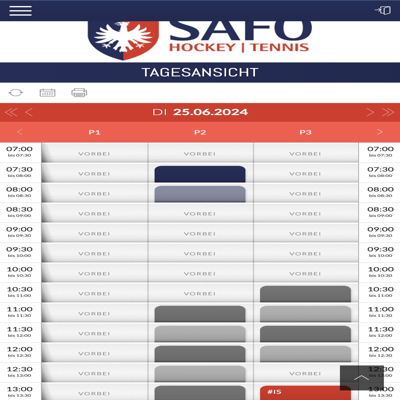

model='gpt-4o'
	answer={}
model='claude-3-5-sonnet-20240620'
	answer={'Platz 2': ['8:00-8:30']}


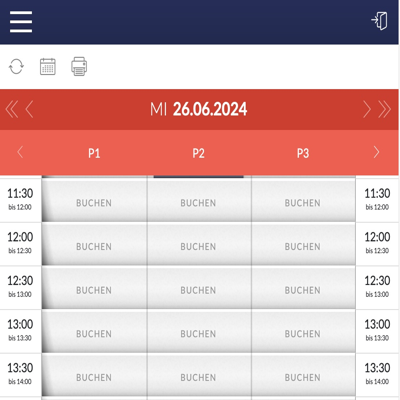

model='gpt-4o'
	answer={'Platz 1': ['11:30 bis 12:00', '12:00 bis 12:30']}
model='claude-3-5-sonnet-20240620'
	answer={'Platz 1': ['11:30-12:00', '12:00-12:30'], 'Platz 2': ['11:30-12:00', '12:00-12:30'], 'Platz 3': ['11:30-12:00', '12:00-12:30']}


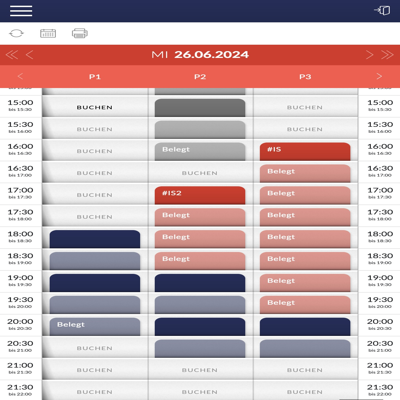

model='gpt-4o'
	answer={'Platz 1': ['16:30-17:00', '17:00-17:30', '17:30-18:00'], 'Platz 2': ['16:30-17:00', '17:00-17:30']}
model='claude-3-5-sonnet-20240620'
	answer={'Platz 1': ['16:30-17:00', '17:00-17:30', '17:30-18:00'], 'Platz 2': ['16:30-17:00']}


In [92]:
from PIL import Image
import io
import base64
from IPython.display import display


models = [LLM.GPT_4o.value, LLM.CLAUDE_3_5_SONNET.value]
testcases = [
    ("tests/data/alles_vorbei.jpeg", ("8:00", "9:30")),
    ("tests/data/alles_frei.jpeg", ("10:00", "12:30")),
    ("tests/data/mixed.jpeg", ("16:30", "20:00")),
]

for img_path, timeslot in testcases:
    img = encode_image(image_path=img_path)

    # let each model generate a description of the table
    table_descriptions = []
    for model in models:
        prompt = "Here is an image of a table. Describe the structure of the table, like its columns, and rows. Describe what kind of data is in the cells."
        messages = [create_user_message(prompt=prompt, images_base64=[img])]
        response = completion(
            model=model,
            messages=messages,
            temperature=0.5,
        )
        table_description = response.choices[0].message.content
        table_descriptions.append(table_description)

    # synthesize the table descriptions into one description
    table_descriptions = "".join([f"\n\nDescription {i+1}:\n{table_description}" for i, table_description in enumerate(table_descriptions)])
    prompt = f"Please combine and summarize the two table descriptions.{table_descriptions}."
    messages = [create_user_message(prompt=prompt)]
    response = completion(
        model=LLM.CLAUDE_3_5_SONNET.value,
        messages=messages,
        temperature=0.5,
    )
    table_description_synthesized = response.choices[0].message.content


    # let each model find the bookable timeslots (in free text, thinking step-by-step)
    prompt = f"""\
    Here is an image of a table and a description:

    {table_description_synthesized}

    Based on the image, what time slots are free and bookable between {timeslot[0]} to {timeslot[1]}? \
    Think step-by-step. Wrap your final answer in <ANSWER>...</ANSWER> tags.
    """
    messages = [create_user_message(prompt=prompt, images_base64=[img])]
    answer_texts = []
    for model in models:
        response = completion(
            model=model,
            messages=messages,
            temperature=0.5,
        )
        answer_text = response.choices[0].message.content
        answer_texts.append(answer_text)

    # finally, parse the answers into a JSON format
    answer_jsons = []
    for answer_text in answer_texts:
        json_format_instructions = '{{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...], ...}}'
        prompt = f"""\
    Please find the ANSWER in the text below. \
    The Answer is between the <ANSWER>...</ANSWER> tags.

    Text:
    {answer_text}

    Parse the answer into the following JSON format:
    {json_format_instructions}
        """
        messages = [create_user_message(prompt=prompt)]
        response = completion(
            model="gpt-3.5-turbo",
            messages=messages,
            response_format={"type": "json_object"},
            temperature=0,
        )
        response_text = response.choices[0].message.content
        response_json = json.loads(response_text)
        answer_jsons.append(response_json)

    # from the jsons, remove any keys that have an empty list as value
    for answer_json in answer_jsons:
        for key in list(answer_json.keys()):
            if not answer_json[key]:
                del answer_json[key]

    # show image
    image = Image.open(io.BytesIO(base64.b64decode(img)))
    display(image.resize((400, 400)))

    # print answers
    print(f"questioned timeslot: {timeslot}")
    for model, answer in zip(models, answer_jsons):
        print(f"{model=}\n\t{answer=}")

In [113]:
def get_disagreements(json1, json2) -> dict:
    # get those key-values where the values are different, e.g. {'Platz 2': ['17:00-17:30']}
    disagreements = {}
    for answer_json in answer_jsons:
        for key, value in answer_json.items():
            if key not in answer_jsons[0] or answer_jsons[0][key] != value:
                disagreements[key] = value
    return disagreements

get_disagreements(answer_jsons[0], answer_jsons[1])

{'Platz 2': ['16:30-17:00']}

In [115]:
# reiterate on the disagreements
model = LLM.CLAUDE_3_5_SONNET.value

disagreements = get_disagreements(answer_jsons[0], answer_jsons[1])

prompt = f"""\
Here is an image of a table. First, describe the structure of the table, like its columns, and rows.
Then check the status of the following time slots:

{disagreements}

Think step-by-step and explain your reasoning. Provide your final answer between <ANSWER>ANSWER> tags.
"""
messages = [create_user_message(prompt=prompt, images_base64=[img])]

for i in range(3):
    response = completion(
        model=model,
        messages=messages,
        temperature=1.0,
    )
    response_text = response.choices[0].message.content
    print(response_text)

    prompt = f"Extract the text that is between the <ANSWER></ANSWER> tags in the following string:\n\n{response_text}"
    messages = [create_user_message(prompt=prompt)]
    response = completion(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0,
    )
    response_text = response.choices[0].message.content
    print(colored(response_text, color="red"))

Let me describe the structure of the table and then check the status of the requested time slot.

Structure of the table:
1. The table shows a schedule for June 26, 2024 (MI 26.06.2024).
2. It has 3 columns labeled P1, P2, and P3, likely representing different places or resources.
3. The rows represent time slots, starting from 15:00 and ending at 22:00, in 30-minute intervals.
4. Each cell in the table shows the status of that time slot for each place: "BUCHEN" (which means "book" in German), "Belegt" (which means "occupied" in German), or specific labels like "#IS" or "#IS2".

Now, let's check the status of the requested time slot:

{'Platz 2': ['16:30-17:00']}

Step-by-step reasoning:
1. "Platz 2" corresponds to the P2 column in the table.
2. The time slot 16:30-17:00 is in the 4th row of the visible part of the table.
3. Looking at the cell in the P2 column for the 16:30-17:00 time slot, we can see that it says "BUCHEN".

<ANSWER>
The status of the time slot 16:30-17:00 for Platz 2

In [105]:
# reiterate on the disagreements
model = LLM.CLAUDE_3_5_SONNET.value
prompt = f"""\
Here is an image of a table and a description:

{table_description_synthesized}

Can you check the status of the following time slots:

{disagreements}

Explain your reasoning. Provide your final answer between <ANSWER>...</ANSWER> tags.
"""
messages = [create_user_message(prompt=prompt, images_base64=[img])]

for model in [LLM.GPT_4o.value, LLM.CLAUDE_3_5_SONNET.value]:
    response = completion(
        model=model,
        messages=messages,
        temperature=0.5,
    )
    response_text = response.choices[0].message.content
    print(response_text)

To check the status of the time slot 16:30-17:00 for Platz 2 (P2), I'll examine the corresponding row in the scheduling table.

Looking at the row for 16:30 bis 17:00 under the P2 column, I can see that the slot is marked as "BUCHEN" in light gray.

Reasoning:
1. The time slot 16:30-17:00 is clearly visible in the table.
2. Under the P2 column for this time slot, we see "BUCHEN" in light gray.
3. According to the description, "BUCHEN" means "book" or "reserve" in German, and light gray indicates that the slot is available.

Therefore, based on the information provided in the image:

<ANSWER>
The time slot 16:30-17:00 for Platz 2 (P2) is available for booking.
</ANSWER>


In [111]:
# reiterate on the disagreements
model = LLM.CLAUDE_3_5_SONNET.value
prompt = f"""\
Here is an image of a table. First, describe the structure of the table, like its columns, and rows.
Then check the status of the following time slots:

{disagreements}

Think step-by-step and explain your reasoning. Provide your final answer between <ANSWER>ANSWER> tags.
"""
messages = [create_user_message(prompt=prompt, images_base64=[img])]

for i in range(3):
    response = completion(
        model=model,
        messages=messages,
        temperature=1.0,
    )
    response_text = response.choices[0].message.content
    print(f"=== {i=} ===")
    print(response_text)

=== i=0 ===
Let me describe the structure of the table and then check the status of the requested time slot:

1. Table structure:
   - The table shows a schedule for June 26, 2024 (MI 26.06.2024).
   - It has 3 columns labeled P1, P2, and P3, likely representing different places or resources.
   - The rows represent time slots, starting from 15:00 and ending at 21:30, with 30-minute intervals.
   - Each cell in the table shows the status of that time slot for each place: "BUCHEN" (available), "Belegt" (occupied), or specific labels like "#IS" or "#IS2".

2. Checking the status of 'Platz 2': ['16:30-17:00']:
   - 'Platz 2' corresponds to the P2 column in the table.
   - The time slot 16:30-17:00 is in the 4th row of the visible schedule.
   - Looking at the intersection of P2 column and the 16:30-17:00 row, we can see that it says "BUCHEN".

3. Interpretation:
   - "BUCHEN" in German means "book" or "reserve".
   - This indicates that the time slot is available for booking.

<ANSWER>
Th

In [110]:
# reiterate on the disagreements
model = LLM.GPT_4o.value
prompt = f"""\
Here is an image of a table. First, describe the structure of the table, like its columns, and rows.
Then check the status of the following time slots:

{disagreements}

Think step-by-step and explain your reasoning. Provide your final answer between <ANSWER>ANSWER> tags.
"""
messages = [create_user_message(prompt=prompt, images_base64=[img])]

for i in range(3):
    response = completion(
        model=model,
        messages=messages,
        temperature=1.0,
    )
    response_text = response.choices[0].message.content
    print(f"=== {i=} ===")
    print(response_text)

=== i=0 ===
### Table Structure
1. **Columns:**
   - There are three columns named **P1**, **P2**, and **P3**.
   
2. **Rows:**
   - Each row represents a half-hour time slot starting from 15:00 and ending at 22:00.

3. **Time Slots:**
   - The time slots are displayed along the right side of the table for each half-hour increment from **15:00 bis 15:30** to **21:30 bis 22:00**.

### Checking the Status of Time Slot for Platz 2
- **Platz (Place) 2** corresponds to column **P2**.
- **Time Slot:** 16:30-17:00

### Analysis
1. Find the row that corresponds to the **16:30-17:00** time slot.
   - This is the row labeled **16:30 bis 17:00** on the right.

2. Check the status in column **P2** (Platz 2) for that time slot.
   - The text in the cell is **"Belegt"** which generally means "Occupied" or "Booked".

### Final Answer
Taking the information into account:

<ANSWER>Belegt</ANSWER>
=== i=1 ===
### Step-by-Step Explanation

#### Step 1: Describe the Structure of the Table

The provided im

In [94]:
for a in answer_texts:
    print("="*100)
    print(a)

To determine the free and bookable time slots between 16:30 and 20:00, we need to examine each 30-minute interval within this period for all three resources (P1, P2, and P3).

1. **16:30 - 17:00:**
   - P1: BUCHEN (Available)
   - P2: BUCHEN (Available)
   - P3: Belegt (Occupied)

2. **17:00 - 17:30:**
   - P1: BUCHEN (Available)
   - P2: #IS2 (Special booking)
   - P3: Belegt (Occupied)

3. **17:30 - 18:00:**
   - P1: BUCHEN (Available)
   - P2: Belegt (Occupied)
   - P3: Belegt (Occupied)

4. **18:00 - 18:30:**
   - P1: Dark blue (Reserved)
   - P2: Belegt (Occupied)
   - P3: Belegt (Occupied)

5. **18:30 - 19:00:**
   - P1: Medium gray (Specific status)
   - P2: Belegt (Occupied)
   - P3: Belegt (Occupied)

6. **19:00 - 19:30:**
   - P1: Dark blue (Reserved)
   - P2: Belegt (Occupied)
   - P3: Belegt (Occupied)

7. **19:30 - 20:00:**
   - P1: Medium gray (Specific status)
   - P2: Medium gray (Specific status)
   - P3: Dark blue (Reserved)

Summarizing the free and bookable slots:



In [81]:
from termcolor import colored


models = ["gpt-4o", "claude-3-5-sonnet-20240620"]

table_descriptions = [
    generate_table_description(
        model=model,
        image_base64=screenshot_base64,
        temperature=1.0
    )
    for model in models
]

table_description_synthesized = synthesize_table_descriptions(
    model=LLM.CLAUDE_3_5_SONNET.value,
    table_descriptions=table_descriptions,
    temperature=0.5,
)
print(colored(f"Synthesized table description:\n\n{table_description_synthesized}", color="red"))

results = []
for model in models:
    print("="*100)
    bookable_timeslots_text = find_bookable_timeslots(
        model=model,
        from_time="17:00",
        to_time="19:00",
        table_description=table_description_synthesized,
        image_base64=screenshot_base64,
    )
    print("-"*100)
    print(f"{model=}\n{bookable_timeslots_text}")

    bookable_timeslots_json = parse_answer_into_json(
        model=model,
        response_text=bookable_timeslots_text,
        json_format_instructions='{{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...], ...}}'
    )
    print(f"{model=}\n{bookable_timeslots_json}")

    results.append(bookable_timeslots_json)

Synthesized table description:

Combined Summary:

The image displays a scheduling or booking table for Tuesday, June 25, 2024 (25.06.2024). The table is structured with four columns: a time column and three resource columns labeled P1, P2, and P3. The rows represent 30-minute time slots from 15:00 (3:00 PM) to 21:30 (9:30 PM).

Key features of the table include:

1. Availability: Cells marked "BUCHEN" (German for "book") indicate available slots.
2. Occupied slots: Marked as "Belegt" (German for "occupied") in light red or gray.
3. Specific reservations: Some cells contain codes or initials (e.g., #IS, MH, MD) in red, possibly indicating priority bookings.
4. Color coding: Various colors (gray, red, dark blue, light blue) are used to represent different statuses or types of reservations.

The table provides a visual representation of resource availability and bookings throughout the afternoon and evening, allowing for easy identification of free slots and occupied periods across the t

In [79]:
results

[{'Platz 1': ['15:00-15:30',
   '15:30-16:00',
   '16:00-16:30',
   '16:30-17:00',
   '17:00-17:30',
   '20:00-20:30'],
  'Platz 2': ['15:30-16:00',
   '16:00-16:30',
   '16:30-17:00',
   '17:00-17:30',
   '17:30-18:00',
   '20:30-21:00'],
  'Platz 3': ['20:30-21:00']},
 {'Platz 1': ['15:00-15:30', '15:30-17:30', '20:30-21:00', '21:00-21:30'],
  'Platz 2': ['15:30-17:30', '17:30-18:00', '21:00-21:30'],
  'Platz 3': ['20:30-21:00', '21:00-21:30']}]

In [50]:

import re

response = completion(
    model="gpt-3.5-turbo",
    messages=[create_user_message(prompt=f'Please find the ANSWER in the text below. The Answer is between the <ANSWER>...</ANSWER> tags.\n\n{response_text}. Put the answer in the following JSON format: {{"Platz 1": ["16:30-17:30", ...], "Platz 2": ["13:00-14:00", ...], ...}}')],
    response_format={"type": "json_object"},
    temperature=0,
)
print(response.choices[0].message.content)

{
    "Platz 1": ["17:00-17:30"],
    "Platz 2": ["17:00-17:30", "17:30-18:00"]
}
